# Pryngles module: Spangler

This module contains all the physics of light scattered on spangles

In [1]:
from pryngles import *

## External modules

In [3]:
import pandas as pd
from collections import OrderedDict as odict
from copy import deepcopy
import random
from scipy.spatial import ConvexHull, convex_hull_plot_2d

## Aliases

In [4]:
print_df=Misc.print_df
sci=Science

## Additional functionalities

In [5]:
from collections import Iterable
def flatten(collection):
    """Flatten a list of objects
    
    Examples:
        list(Misc.flatten(["cosa"]))
        list(Misc.flatten([["cosa"]]))
        list(Misc.flatten([["cosa","perro"]]))
        list(Misc.flatten([[1,"perro"],object,float]))
    """
    for i in collection:
        if isinstance(i, Iterable) and not isinstance(i, basestring):
            for subc in flatten(i):
                yield subc
        else:
            yield i
            
Misc.flatten=flatten

## Constants

In [6]:
#Colors: Given in hue (0-360), level (0: black-1: white), saturation (0-1)

#Type of spangles
SPANGLE_COLORS=dict()

#Planetary spangles
SOLID_SPANGLE=0
SPANGLE_COLORS[SOLID_SPANGLE]=[27,0.5,1.0]

ATMOSPHERIC_SPANGLE=1
SPANGLE_COLORS[ATMOSPHERIC_SPANGLE]=[27,0.5,1.0]

LIQUID_SPANGLE=2
SPANGLE_COLORS[LIQUID_SPANGLE]=[27,0.5,1.0]

#Ring or disks spangles
GRANULAR_SPANGLE=3
SPANGLE_COLORS[GRANULAR_SPANGLE]=[59,0.7,0.4]

#Semitransparent
GASEOUS_SPANGLE=4
SPANGLE_COLORS[GASEOUS_SPANGLE]=[27,0.5,1.0]

#Stellar spangles
STELLAR_SPANGLE=5
SPANGLE_COLORS[STELLAR_SPANGLE]=[59,0.7,1.0]

#List of semitransparent spangles
SEMITRANSPARENT_SPANGLES=[GRANULAR_SPANGLE,GASEOUS_SPANGLE]

#Color of shadow
SHADOW_COLOR=[180,0.6,0.0]
SHADOW_COLOR_OBS=[180,0.2,0.0]

## The Spangler class

This class contains a family of routines useful for spangling different kind of objects.

In [7]:
Spangler_doc=\
"""A Spangler associated to an object or set of objects.
    
   There are two ways to initialize a Spangler:
    
        Creating a Spangler for a single object:
        
            Mandatory:

                nspangles: int, default = 0:
                    Number of spangles in spangling.

            Optional:

                body_hash: string, default = None:
                    Hash identifying the body to which spangles are associated 
                    (see Body documentation for explanation about hash).

                spangle_type: int, default = 0:
                    Type of spangle (see *_SPANGLE in Consts module).

                n_equ: numpy Array (3), default = [0,0,1]:
                    unitary vector normal to {equ} (equatorial) plane.

                alpha_equ: float, default = 0:
                    Roll angle of x-axis of equatorial system (not implemented yet)

                center_equ: numpy Array (3), default = [0,0,0]:
                    Position of the spnagler in the {equ} (equatorial) system.

                center_ecl: numpy Array (3), default = [0,0,0]:
                    Position of the spnagler in the {ecl} (ecliptic) system.
                    
                w, q0: float [rad/ut, rad], default = 0, 0:
                    Angular velocity and reference latitude at t = 0.

        Joining a set of Spanglers (several objects):

            spanglers: list of Spanglers. default = []:
                Set of spanglers to join.

Core attributes:

    nspangles: int:
        Total number of spangles.

    data: Pandas DataFrame: 
        Dataframe containing all the information about the spangling.
        For Columns see global variable SPANGLER_COLUMNS.
"""

In [8]:
#Columns of spangling
SPANGLER_COLUMNS=odict({
    "sphash":"",

    #Type of spangle
    "spangle_type":SOLID_SPANGLE, #For a list of spangle types see the constants module.
    "dim":2, #Dimension of the spangle, 3: sphere, 2: circle, ring

    #Lengh-scale
    "scale":1, #The length scale of the body, eg. for a ring this is the outer radius

    #Body parameters
    "n_equ":[0,0,1], #Direction of the equator of the body with respect
    "alpha_equ":0, #Zero meridian of equatorial system
    "w":0, #Rotational angular velocity [rad/ut]
    "q0":0, #Initial time [rad], Longitude (azimutal angle) are calculated as: q = q0 + w (t - t0)

    #Coordinates of the spangle (cartesian and spherical) in the body-centric system
    "center_equ":[0,0,0],#Center of the body with respect to barycenter
    "x_equ":1,"y_equ":0,"z_equ":0, #Cartesian coordinates
    "r_equ":1,"q_equ":0,"f_equ":0, #Spherical coordinates: q: longitude, f: latitude
    "ns_equ":[0,0,1], #Unitary vector normal to the spangle

    #Coordinates of the spangle (cartesian and spherical) in the ecliptic system
    "center_ecl":[0,0,0], #Center of the body with respect to barycenter
    "x_ecl":1,"y_ecl":0,"z_ecl":0, #Cartesian coordinates of the spangle
    "ns_ecl":[0,0,1],#Unitary vector normal to the spangle, calculated in the class

    #Coordinates of the spangle (cartesian and spherical) in the observer system
    "center_obs":[0,0,0], #Center of the body with respect to observer
    "x_obs":1,"y_obs":0,"z_obs":0, #Cartesian coordinates of the spangle
    "rho_obs":1,"az_obs":0,"cost_obs":0, #Cylindrical coordinates of the spangle: rho, q, cos(theta)
    "cos_obs":1, #Angle between normal to spangle and direction of observer
    "d_obs":1, #Distance of the Spangle to light-source
    
    #Coordinates of the spangle (cartesian and spherical) in the light-source system
    "center_luz":[0,0,0],#Center of the body with respect to light
    "x_luz":1,"y_luz":0,"z_luz":0,#Calculated in the class
    "rho_luz":1,"az_luz":0,"cost_luz":0, #Cylindrical coordinates of the spangle: rho, q, cos(theta)
    "cos_luz":1, #Angle between normal to spangle and direction of light-source
    "d_luz":1, #Distance of the Spangle to light-source

    #Coordinates of the spangle (cartesian and spherical) in the intersection system
    "center_int":[0,0,0],#Center of the body 
    "x_int":1,"y_int":0,"z_int":0,#Cartesian coordinates
    "rho_int":1,"az_int":0,"cost_int":0, #Pseudo cylindrical coordinates (rho, q, cos(theta))
    "cos_int":1, #Angle between normal to spangle and direction of intersection
    "d_int":1, #Distance of the Spangle to intersection

    #Geometrical parameters
    "asp":1.0, #Effective area of the spangle
    "dsp":1.0, #Effective diameter of spangle, dsp = 2*(asp/pi)**0.5

    #Optical parameters
    "albedo_gray_normal":1.0,
    "tau_gray_optical":0.0,
    
    #Special states
    "unset":True, #State has not been set
    "hidden":False, #The spangle is not taken into account for photometry
    "source":False, #The spangle belongs to a light-source (it does not reflect light)
})

SPANGLER_VISIBILITY_STATES=odict({
    #Spangle state
    "visible":False, #The spangle is visible from observer
    "shadow":False, #The spangle is in the shadow of other spangle
    "indirect":False, #The spangle is indirectly illuminated
    "emit":False, #The spangle is emmitting
    "intersect":False, #Intermediate state to calculate intersections
})
SPANGLER_COLUMNS.update(SPANGLER_VISIBILITY_STATES)

SPANGLER_SOURCE_STATES=odict({
    "illuminated":False, #The spangle is illuminated by the light-source
    "transmit":False, #The spangle is illuminated but transmitting light
    "transit":False, #The spangle is transiting
    "occult":False, #The spangle is occulted by a light source
})
SPANGLER_COLUMNS.update(SPANGLER_SOURCE_STATES)

SPANGLER_COL_COPY=["center","x","y","z","rho","az","cost","cos","d"]
SPANGLER_COL_LUZ=[column+"_luz" for column in SPANGLER_COL_COPY]
SPANGLER_COL_OBS=[column+"_obs" for column in SPANGLER_COL_COPY]
SPANGLER_COL_INT=[column+"_int" for column in SPANGLER_COL_COPY]

SPANGLER_RING_BORDER=100

In [24]:
class Spangler(PrynglesCommon):
    
    def __init__(self,
                 #Initialization using specific options
                 #Basic
                     nspangles=1,
                     sphash=None,
                     n_equ=SPANGLER_COLUMNS["n_equ"],
                     alpha_equ=SPANGLER_COLUMNS["alpha_equ"],
                     center_equ=SPANGLER_COLUMNS["center_equ"],
                     center_ecl=SPANGLER_COLUMNS["center_ecl"],
                 #Optional
                     w=SPANGLER_COLUMNS["w"],
                     q0=SPANGLER_COLUMNS["q0"],
                 #Initialization with a list of 
                     spanglers=[]
                ):
        
        #Common attributes
        self.n_obs=[0,0,1]
        self.n_luz=[0,0,1]
        #Direction of the observer in spherical coordinates
        self.rqf_obs=[0,0,90*Consts.deg]
        #Transformation matrices from equatorial to ecliptic coordinates
        self.M_equ2ecl=dict()
        self.M_ecl2equ=dict()
        #Convex hulls of spanglers
        self.qhulls=dict()
        
        #Create a spanglers with a list of other spanglers
        if len(spanglers)>0:
            verbose(VERB_SIMPLE,f"Joining {len(spanglers)} spanglers")
            self._join_spanglers(spanglers)
            
        #Create a spangler with the desired options
        else:
            #Attributes
            self.nspangles=nspangles
            self.geometry="Vanilla"
            
            #Default property values
            self._defaults=deepcopy(SPANGLER_COLUMNS)

            if not sphash:
                self.sphash=str(random.getrandbits(16))
                verbose(VERB_VERIFY,f"Generating random hash {self.sphash}")
            else:
                self.sphash=sphash
                
            self._defaults.update(dict(sphash=self.sphash))
            
            #Update other parameters
            self._defaults.update(
                dict(w=w,q0=q0)
            )

            #Create Spangler dataframe
            if self.nspangles>0:
                
                #Create a simple DataFrame with the default values
                self.data=pd.DataFrame([list(self._defaults.values())]*self.nspangles,
                                       columns=self._defaults.keys())

                #Update positions
                self.set_positions(
                    n_equ=n_equ,alpha_equ=alpha_equ,
                    center_equ=center_equ,center_ecl=center_ecl,
                    t=None
                )
        
            else:        
                verbose(VERB_SIMPLE,f"Creating a blank Spangler")
                #Creat a blank DataFrame
                self.data=pd.DataFrame(columns=self._defaults.keys())
        
    def set_rotation(self,sphash,w,t0):
        """Set rotational parameters
        """
        cond=(self.data.sphash==sphash)
        self.data.loc[cond,"w"]=w
        self.data.loc[cond,"t0"]=t0
    
    def reset_state(self):
        """Reset spangler state
        """
        self.data[list(SPANGLER_SOURCE_STATES)+list(SPANGLER_VISIBILITY_STATES)]=False
        self.data["unset"]=True

    def set_scale(self,scale):
        """Set scale
        """
        lengths=[
            "x_equ","y_equ","z_equ",
            "x_ecl","y_ecl","z_ecl",
            "x_obs","y_obs","z_obs","d_obs",
            "x_luz","y_luz","z_luz","d_luz",
            "r_equ","rho_obs","rho_luz",
            "dsp",
        ]
        self.scale=scale
        self.data[lengths]*=self.scale
        areas=[
            "asp",
        ]
        self.data[areas]*=self.scale**2
        vectors=[
            "center_ecl",
            "center_equ",
            "center_obs",
        ]
        for vector in vectors:
            self.data[vector]=[np.array(v)*scale for v in self.data[vector]]
        
    def _join_spanglers(self,spanglers):
        """
        Join spanglers into a single spangler

        Parameters:
            spanglers: list of Spanglers:
                Spanglers to join.
        """
        self.sphash=[]
        for spangler in spanglers:
            if not isinstance(spangler,Spangler):
                raise AssertionError(f"One of the spangler is not an Spangler instance")
                
            if spangler.sphash in self.sphash:
                raise ValueError(f"Hash '{spangler.sphash}' already included in spangler '{self.sphash}'")
                
            self.sphash+=[spangler.sphash]
        
        #Set of spanglers
        self.spanglers=spanglers

        #Concatenate data
        datas=[spangler.data for spangler in spanglers]
        self.data=pd.concat(datas,ignore_index=True)

        self.M_equ2ecl=dict()
        for spangler in spanglers:
            self.M_equ2ecl.update(spangler.M_equ2ecl)

        #Join properties
        self.nspangles=len(self.data)
        self.geometry="Join"
    
Spangler.__doc__=Spangler_doc

### Set positions

In [25]:
def set_positions(self,
                  n_equ=[],alpha_equ=0,
                  center_equ=[],center_ecl=[],
                  t=None
                 ):
    """
    Set the positions and orientation of spanglers in all reference systems.

    Parameters:

        n_equ: list/array (3), default = []:
            Normal vector towards north pole equatorial system.

        alpha_equ: float, default = 0:
            Roll angle of x-axis of equatorial system (not implemented yet)

        center_equ: list/array (3), default = []:
            Location of the center of the body with respect to the barycenter.
            
        center_ecl: list/array (3), default = []:
            Location of the center of the body with respect to the barycenter.
            
        t: float, default = None:
            Time.  This quantity is used to update the equatorial coordinates.
            If None, equatorial coordinates are not set.

    Return:
        None

    Update:

        Coordinates of the spangles, (x_ecl,y_ecl,z_ecl).

        Rotation matrices M_equ2ecl
    """
    verbose(VERB_VERIFY,f"Setting positions")

    #Update normal vectors
    qupdate=False
    
    #Update center
    if len(center_equ)>0:
        verbose(VERB_VERIFY,f"Updating center in {{equ}} to {center_equ}")
        self.data["center_equ"]=[center_equ]*self.nspangles
    if len(center_ecl)>0:
        verbose(VERB_VERIFY,f"Updating center {{ecl}} to {center_ecl}")
        self.data["center_ecl"]=[center_ecl]*self.nspangles
        
    if len(n_equ)>0:
        verbose(VERB_VERIFY,f"Generating equatorial transformation matrices from n_equ = {n_equ}")
        
        #Unitary equatorial vector
        n_equ,one=spy.unorm(n_equ)
        self.data["n_equ"]=[n_equ]*self.nspangles

        #Transformation matrices
        self.M_equ2ecl[self.sphash],M_ecl2equ=sci.rotation_matrix(n_equ,alpha_equ)
        
        qupdate=True

    #Update equatorial coordinates by rotation
    if t is not None:
        verbose(VERB_VERIFY,f"Updating rotations at t = {t}")

        self.data["q_equ"]=[q+q0+w*t for q,w,q0 in zip(self.data.q_equ,self.data.w,self.data.q0)]
        self.data[["x_equ","y_equ","z_equ"]]=\
            [sci.cartesian(r) for r in np.array(self.data[["r_equ","q_equ","f_equ"]])]

        qupdate=True
        
    if qupdate:
        #Update normal vectors
        cond=(self.data.dim==2)
        self.data.loc[cond,"ns_equ"]=pd.Series([[0,0,1]]*cond.sum(),dtype=object)
        lista=[spy.unorm(list(r))[0] for r in np.array(self.data[~cond][["x_equ","y_equ","z_equ"]])]
        self.data.loc[~cond,"ns_equ"]=pd.Series(lista,dtype=object)
        
    #Convert from equatorial to ecliptic
    verbose(VERB_VERIFY,f"Converting to equatorial")
    self.data[["x_ecl","y_ecl","z_ecl"]]=\
        [np.matmul(self.M_equ2ecl[sph],r+cequ)+cecl\
         for sph,r,cequ,cecl in zip(self.data.sphash,
                                   np.array(self.data[["x_equ","y_equ","z_equ"]]),
                                   self.data.center_equ,self.data.center_ecl)]
    
    #Update spangles orientations
    verbose(VERB_VERIFY,f"Generating normal vectors")
    self.data["ns_ecl"]=[np.matmul(self.M_equ2ecl[sph],n) for sph,n in zip(self.data.sphash,
                                                                         self.data.ns_equ)]
    
    #Update velocities
    #Not implemented yet
    
Spangler.set_positions=set_positions

### Test class

In [26]:
if IN_JUPYTER:
    def test_init(self):
        
        Verbose.VERBOSITY=VERB_SIMPLE
        
        print("Basic definition:")
        sg=Spangler(nspangles=1,center_equ=[0,0,0],n_equ=[1,0,0])
        Misc.print_df(sg.data.head(1))
        return 

        print("\nCenter equ:")
        sg=Spangler(nspangles=3,center_equ=[0,0,1])
        Misc.print_df(sg.data.head(1))

        print("\nCenter ecl:")
        sg=Spangler(nspangles=3,center_ecl=[0,0,1])
        Misc.print_df(sg.data.head(1))

        print("\nRotation:")
        sg=Spangler(nspangles=3,w=30*Consts.deg,q0=40*Consts.deg)
        sg.set_positions(t=1)
        Misc.print_df(sg.data.head(1))

        print("\nJoin:")
        sg1=Spangler(sphash="Body 1",nspangles=3,w=40*Consts.deg)
        sg2=Spangler(sphash="Body 2",nspangles=3,w=30*Consts.deg)
        sg=Spangler(spanglers=[sg1,sg2])
        sg.set_positions(t=1)
        Misc.print_df(sg.data)

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_init=test_init
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

Basic definition:


,sphash,spangle_type,dim,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_obs,x_obs,y_obs,z_obs,rho_obs,az_obs,cost_obs,cos_obs,d_obs,center_luz,x_luz,y_luz,z_luz,rho_luz,az_luz,cost_luz,cos_luz,d_luz,center_int,x_int,y_int,z_int,rho_int,az_int,cost_int,cos_int,d_int,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,shadow,indirect,emit,intersect,illuminated,transmit,transit,occult
0,41780,0,2,1,"[1.0, 0.0, 0.0]",0,0,0,"[0, 0, 0]",1,0,0,1,0,0,"[0, 0, 1]","[0, 0, 0]",0.0,1.0,0.0,"[1.0, 0.0, 0.0]","[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,1.0,1.0,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False


.
----------------------------------------------------------------------
Ran 1 test in 0.029s

OK


In [27]:
if IN_JUPYTER:
    def test_reset(self):

        Verbose.VERBOSITY=VERB_SIMPLE

        sg=Spangler(nspangles=100)
        sg.reset_state()
        print_df(sg.data.head())

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_reset=test_reset
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

,sphash,spangle_type,dim,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_obs,x_obs,y_obs,z_obs,rho_obs,az_obs,cost_obs,cos_obs,d_obs,center_luz,x_luz,y_luz,z_luz,rho_luz,az_luz,cost_luz,cos_luz,d_luz,center_int,x_int,y_int,z_int,rho_int,az_int,cost_int,cos_int,d_int,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,shadow,indirect,emit,intersect,illuminated,transmit,transit,occult
0,57787,0,2,1,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",1,0,0,1,0,0,"[0, 0, 1]","[0, 0, 0]",1.0,0.0,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,1.0,1.0,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False
1,57787,0,2,1,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",1,0,0,1,0,0,"[0, 0, 1]","[0, 0, 0]",1.0,0.0,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,1.0,1.0,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False
2,57787,0,2,1,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",1,0,0,1,0,0,"[0, 0, 1]","[0, 0, 0]",1.0,0.0,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,1.0,1.0,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False
3,57787,0,2,1,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",1,0,0,1,0,0,"[0, 0, 1]","[0, 0, 0]",1.0,0.0,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,1.0,1.0,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False
4,57787,0,2,1,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",1,0,0,1,0,0,"[0, 0, 1]","[0, 0, 0]",1.0,0.0,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,1.0,1.0,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False


.
----------------------------------------------------------------------
Ran 1 test in 0.031s

OK


In [28]:
if IN_JUPYTER:
    def test_scale(self):

        Verbose.VERBOSITY=VERB_SIMPLE

        sg=Spangler(center_ecl=[1,1,1],center_equ=[1,1,1])
        print_df(sg.data)

        sg.set_scale(5)
        print_df(sg.data)

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_scale=test_scale
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

,sphash,spangle_type,dim,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_obs,x_obs,y_obs,z_obs,rho_obs,az_obs,cost_obs,cos_obs,d_obs,center_luz,x_luz,y_luz,z_luz,rho_luz,az_luz,cost_luz,cos_luz,d_luz,center_int,x_int,y_int,z_int,rho_int,az_int,cost_int,cos_int,d_int,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,shadow,indirect,emit,intersect,illuminated,transmit,transit,occult
0,8807,0,2,1,"[0.0, 0.0, 1.0]",0,0,0,"[1, 1, 1]",1,0,0,1,0,0,"[0, 0, 1]","[1, 1, 1]",3.0,2.0,2.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,1.0,1.0,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False


,sphash,spangle_type,dim,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_obs,x_obs,y_obs,z_obs,rho_obs,az_obs,cost_obs,cos_obs,d_obs,center_luz,x_luz,y_luz,z_luz,rho_luz,az_luz,cost_luz,cos_luz,d_luz,center_int,x_int,y_int,z_int,rho_int,az_int,cost_int,cos_int,d_int,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,shadow,indirect,emit,intersect,illuminated,transmit,transit,occult
0,8807,0,2,1,"[0.0, 0.0, 1.0]",0,0,0,"[5, 5, 5]",5,0,0,5,0,0,"[0, 0, 1]","[5, 5, 5]",15.0,10.0,10.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",5,0,0,5,0,0,1,5,"[0, 0, 0]",5,0,0,5,0,0,1,5,"[0, 0, 0]",1,0,0,1,0,0,1,1,25.0,5.0,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False


.
----------------------------------------------------------------------
Ran 1 test in 0.033s

OK


### Populate Spangler

In [29]:
def populate_spangler(self,
                      preset=False,
                      scale=1,seed=0,spangle_type=SOLID_SPANGLE,
                      geometry="circle",**geometry_args):
    
    """Populate data of a Spangler using points generated with a given geometry.
    
    Parameters:
    
        preset: boolean, default = False:
            If true the spangler is populated with preset data.
            
        scale: float. default = 1:
            Scale size of the object.
            
        seed: integer. default = 0:
            Value of the integer seed of random number generation (if 0 no random seed is set).
            If a non-zero seed is used the position of the spangle will be always the same.
            
        geometry: string, default = "circle":
            Geometry of the Sampler.  Available: "circle", "ring", "sphere"
            
        geometry_args: dictionary:
            See Sampler methods documentation.
             
    """
    #Check if preset
    if preset:
        verbose(VERB_VERIFY,f"Populating spangler from preset for {geometry}")
        preset=(geometry,geometry_args)
        self.sample=Sampler(preset=preset,N=self.nspangles,seed=seed)   
    else:
        self.sample=Sampler(N=self.nspangles,seed=seed)
        exec(f"self.sample.gen_{geometry}(**geometry_args)")

    self.geometry=geometry
    self.data["dim"]=self.sample.dim
    self.data["spangle_type"]=spangle_type

    if self.sample.dim>2:
        #Purge sample if it is in 3d
        verbose(VERB_VERIFY,f"Purging 3d sample")
        self.sample.purge_sample()
        
    elif self.geometry == "ring":
        #Add hidden spangles to ring inner borders
        pp_border=np.zeros((SPANGLER_RING_BORDER,3))
        ss_border=np.zeros((SPANGLER_RING_BORDER,3))
        for i,theta in enumerate(np.linspace(0,2*np.pi,SPANGLER_RING_BORDER)):
            pp_border[i]=[self.sample.ri,theta,0]
            ss_border[i]=[self.sample.ri*np.cos(theta),
                          self.sample.ri*np.sin(theta),
                          0]
        self.sample.pp=np.vstack((self.sample.pp,pp_border))
        self.sample.ss=np.vstack((self.sample.ss,ss_border))
        self.sample.N+=SPANGLER_RING_BORDER
                
    #Check if number of samples is not equal to that of spangles
    if self.sample.N!=self.nspangles:
        verbose(VERB_SYSTEM,f"Sample size {self.sample.N} is different from spangles {self.nspangles}. Adjusting.")
        dif=self.sample.N-self.nspangles
        if dif>0:
            verbose(VERB_SYSTEM,f"Adding {dif} entries to DataFrame")
            for i in range(dif):
                df=pd.DataFrame([self.data.iloc[-1]])
                self.data=pd.concat([self.data,df],ignore_index=True)
        else:
            verbose(VERB_SYSTEM,f"Removing {-dif} entries to DataFrame")
            self.data.drop(range(self.nspangles+dif,self.nspangles),inplace=True)
        self.nspangles=self.sample.N
    
    #Area
    self.data["asp"]=self.sample.aes*scale**2
    self.data["dsp"]=2*(self.data["asp"]/np.pi)**0.5
    
    #Update scale
    self.data["scale"]=scale

    #Store positions in DataFrame
    self.data[["x_equ","y_equ","z_equ"]]=self.sample.ss*scale
    self.data[["r_equ","q_equ","f_equ"]]=self.sample.pp
    self.data["r_equ"]*=scale

    #Update normal vectors
    if self.sample.dim>2:
        self.data["ns_equ"]=[spy.unorm(list(r))[0] for r in np.array(self.data[["x_equ","y_equ","z_equ"]])]
    else:
        self.data["ns_equ"]=pd.Series([[0,0,1]]*self.nspangles,dtype=object)
        
    #Hide border points in case of ring
    if geometry == "ring":
        self.data.loc[self.nspangles-SPANGLER_RING_BORDER:self.nspangles,"hidden"]=True
        
    #Update positions
    self.set_positions()
    
Spangler.populate_spangler=populate_spangler

<IPython.core.display.Javascript object>


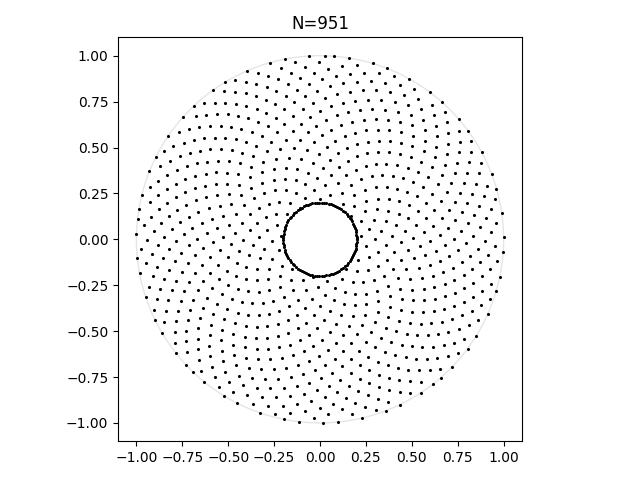

,sphash,spangle_type,dim,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_obs,x_obs,y_obs,z_obs,rho_obs,az_obs,cost_obs,cos_obs,d_obs,center_luz,x_luz,y_luz,z_luz,rho_luz,az_luz,cost_luz,cos_luz,d_luz,center_int,x_int,y_int,z_int,rho_int,az_int,cost_int,cos_int,d_int,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,shadow,indirect,emit,intersect,illuminated,transmit,transit,occult
0,14123,4,2,2,"[1.0, 0.0, 0.0]",0,0,0,"[0, 0, 0]",0.387129,-0.107400,0.0,0.401751,6.012565,0.0,"[0, 0, 1]","[0, 0, 0]",0.0,0.387129,-0.107400,"[1.0, 0.0, 0.0]","[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,0.014176,0.134348,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False
1,14123,4,2,2,"[1.0, 0.0, 0.0]",0,0,0,"[0, 0, 0]",-0.215973,0.345597,0.0,0.407531,2.129343,0.0,"[0, 0, 1]","[0, 0, 0]",0.0,-0.215973,0.345597,"[1.0, 0.0, 0.0]","[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,0.014176,0.134348,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False
2,14123,4,2,2,"[1.0, 0.0, 0.0]",0,0,0,"[0, 0, 0]",-0.075234,-0.406325,0.0,0.413231,4.529306,0.0,"[0, 0, 1]","[0, 0, 0]",0.0,-0.075234,-0.406325,"[1.0, 0.0, 0.0]","[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,0.014176,0.134348,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False


  VERB1::__init__:: Loading sampler from preset: ('ring', {'ri': 0.2})


<IPython.core.display.Javascript object>


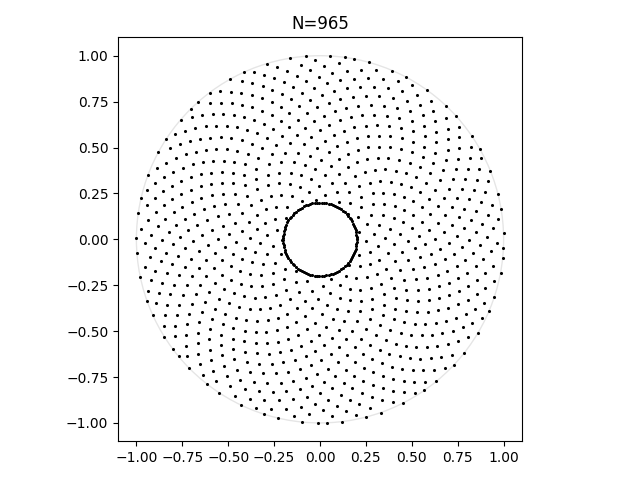

,sphash,spangle_type,dim,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_obs,x_obs,y_obs,z_obs,rho_obs,az_obs,cost_obs,cos_obs,d_obs,center_luz,x_luz,y_luz,z_luz,rho_luz,az_luz,cost_luz,cos_luz,d_luz,center_int,x_int,y_int,z_int,rho_int,az_int,cost_int,cos_int,d_int,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,shadow,indirect,emit,intersect,illuminated,transmit,transit,occult
0,5864,0,2,1,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",-0.016061,-0.201420,0.0,0.202060,4.632820,0.0,"[0, 0, 1]","[0, 0, 0]",-0.016061,-0.201420,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,0.003487,0.066628,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False
1,5864,0,2,1,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",0.149969,0.139598,0.0,0.204886,0.749598,0.0,"[0, 0, 1]","[0, 0, 0]",0.149969,0.139598,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,0.003487,0.066628,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False
2,5864,0,2,1,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",-0.207667,-0.001655,0.0,0.207673,3.149561,0.0,"[0, 0, 1]","[0, 0, 0]",-0.207667,-0.001655,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,0.003487,0.066628,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False


  VERB1::purge_sample:: Purging sample


<IPython.core.display.Javascript object>


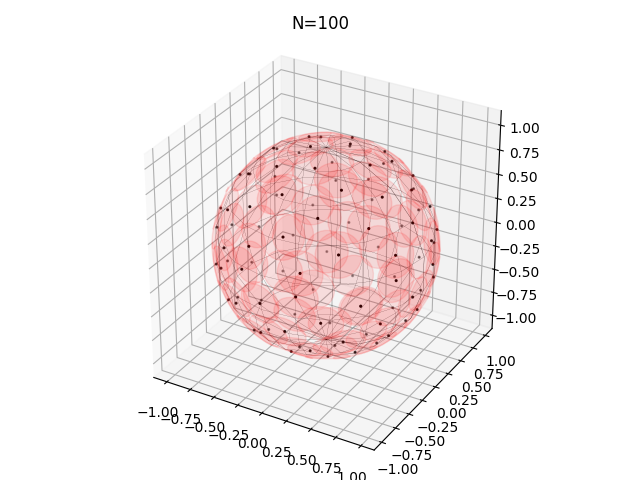

,sphash,spangle_type,dim,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_obs,x_obs,y_obs,z_obs,rho_obs,az_obs,cost_obs,cos_obs,d_obs,center_luz,x_luz,y_luz,z_luz,rho_luz,az_luz,cost_luz,cos_luz,d_luz,center_int,x_int,y_int,z_int,rho_int,az_int,cost_int,cos_int,d_int,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,shadow,indirect,emit,intersect,illuminated,transmit,transit,occult
0,58524,0,3,3,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",0.381582,-0.183017,-2.97,3.0,5.835968,-1.429257,"[0.12719395512303389, -0.06100571924139298, -0.9899999999999999]","[0, 0, 0]",0.381582,-0.183017,-2.97,"[0.12719395512303389, -0.06100571924139298, -0.9899999999999999]","[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,1.130973,1.2,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False
1,58524,0,3,3,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",-0.271838,0.676760,-2.91,3.0,1.952746,-1.325231,"[-0.09061259123825989, 0.22558669798790898, -0.9700000000000001]","[0, 0, 0]",-0.271838,0.676760,-2.91,"[-0.09061259123825989, 0.22558669798790898, -0.9700000000000001]","[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,1.130973,1.2,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False
2,58524,0,3,3,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",-0.329712,-0.876807,-2.85,3.0,4.352709,-1.253236,"[-0.10990398845091585, -0.2922689058428573, -0.9500000000000001]","[0, 0, 0]",-0.329712,-0.876807,-2.85,"[-0.10990398845091585, -0.2922689058428573, -0.9500000000000001]","[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,1.130973,1.2,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False


.
----------------------------------------------------------------------
Ran 1 test in 0.854s

OK


In [30]:
if IN_JUPYTER:
    def test_pop(self):
        Verbose.VERBOSITY=VERB_SIMPLE

        #No preset
        sg=Spangler(nspangles=850,n_equ=[1,0,0])
        sg.populate_spangler(geometry="ring",
                             spangle_type=GASEOUS_SPANGLE,
                             scale=2,seed=1,ri=0.2)
        sg.sample.plot()
        sg.sample.ax.set_title(f"N={sg.nspangles}")
        sg.sample.fig.tight_layout()
        print_df(sg.data.head(3))

        #Using preset
        sg=Spangler(nspangles=850)
        sg.populate_spangler(geometry="ring",
                             preset=True,
                             spangle_type=SOLID_SPANGLE,ri=0.2)
        sg.sample.plot()
        sg.sample.ax.set_title(f"N={sg.nspangles}")
        sg.sample.fig.tight_layout()
        print_df(sg.data.head(3))
    
        #Sphere
        sg=Spangler(nspangles=100)
        sg.populate_spangler(geometry="sphere",scale=3,seed=1)
        sg.sample.plot(spangled=dict(color='r',alpha=0.1))
        sg.sample.ax.set_title(f"N={sg.nspangles}")
        sg.sample.fig.tight_layout()
        print_df(sg.data.head(3))
        
        Verbose.VERBOSITY=VERB_NONE
        
    class Test(unittest.TestCase):pass
    Test.test_pop=test_pop
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

### Plot3D

In [31]:
def plot3d(self,
           center_at=None,
           not_plot=[],
           factor=1.2,
           show_hidden=True,
           figsize=(5,5)
          ):
    """Plot spangle in 3d.

    Optional parameters:
    
        center_at: string, default = None:
            Hash of the object around which the plotting will be centered at (see sphash column
            of the Spangler DataFrame).
            
        not_plot: list of strings, default = []:
            List of object hashes to not plot.

        show_hidden: boolean, default = True:
            If True show hidden spangles (used to create convex hull of objects).
            
        factor: float, default = 1.2:
            Size of the 
    """
    bgcolor='k'

    #Center
    cond=(self.data.sphash==center_at)
    x_cen,y_cen,z_cen=self.data[cond][["x_ecl","y_ecl","z_ecl"]].mean() if sum(cond)>0 else np.array([0,0,0])
    
    #Figure
    fig=plt.figure(figsize=figsize)
    fig.patch.set_facecolor(bgcolor)
    ax=fig.add_subplot(111,projection='3d',facecolor=bgcolor)
    ax.axis("off")
    
    #Spangles
    for i in range(self.nspangles):

        #Avoid plotting 
        sphash=self.data.loc[i,"sphash"]
        if sphash in not_plot:
            continue
        
        #Reference transparency of spangles
        alpha_base=0.5

        #Avoid hidden spangles
        if self.data.loc[i,"hidden"]:
            continue

        spangle_type=self.data.loc[i,"spangle_type"]

        #Define color according to illumination
        if self.data.loc[i,"illuminated"]:
            color=Misc.rgb(SPANGLE_COLORS[spangle_type]) #Planet color
        else:
            color=Misc.rgb(SHADOW_COLOR) #Gray

        if self.data.loc[i,"transmit"]:
            alpha_base=0.2

        #Define alpha according to albedo
        alpha=alpha_base*self.data.albedo_gray_normal[i]

        center=[self.data.x_ecl[i]-x_cen,self.data.y_ecl[i]-y_cen,self.data.z_ecl[i]-z_cen]
        radius=self.data.dsp[i]/2
        zDir=self.data.ns_ecl[i]

        #Change properties according to visibility
        ec=color
        lw=0
        if ~self.data.loc[i,"visible"]:
            ec='k'
            lw=0
            alpha*=0.5

        #verbose(VERB_DEEP,i,center,radius,zDir)
        Plot.circle3d(ax,
                      center=center,
                      radius=radius,
                      zDir=zDir,
                      color=color,alpha=alpha,ec=ec,lw=lw)

    #Scatter plot of transmit
    cond=(~self.data.hidden)&(self.data.transmit)
    ax.scatter(self.data[cond].x_ecl,self.data[cond].y_ecl,self.data[cond].z_ecl,
               marker='v',s=10,ec='w',fc='None',alpha=0.1)
        
        
    #Aspect
    ax.set_box_aspect([1,1,1])

    #Zoom around center
    cond=(self.data.sphash==center_at)
    cond=cond if sum(cond)>0 else [True]*self.nspangles

    #Not 
    cond=cond&(~self.data.sphash.isin(not_plot))
    
    #Range
    maxval=1.0*np.abs(self.data[cond][["x_ecl","y_ecl","z_ecl"]].to_numpy()-[x_cen,y_cen,z_cen]).max()
    ax.set_xlim(-maxval,maxval)
    ax.set_ylim(-maxval,maxval)
    ax.set_zlim(-maxval,maxval)
    
    #Decoration
    xmin,xmax=factor*np.array(list(ax.get_xlim()))
    ymin,ymax=factor*np.array(list(ax.get_ylim()))
    zmin,zmax=factor*np.array(list(ax.get_zlim()))

    #Axis
    ax.plot([xmin,xmax],[0,0],[0,0],'w-',alpha=0.3)
    ax.plot([0,0],[ymin,ymax],[0,0],'w-',alpha=0.3)
    ax.plot([0,0],[0,0],[zmin,zmax],'w-',alpha=0.3)
    ax.text(xmax,0,0,r"$x_{ecl}$",color='w',alpha=0.5,fontsize=8)
    ax.text(0,ymax,0,r"$y_{ecl}$",color='w',alpha=0.5,fontsize=8)
    ax.text(0,0,zmax,r"$z_{ecl}$",color='w',alpha=0.5,fontsize=8)
    
    increase=1.05*factor*maxval
    if "n_luz" in self.__dict__:
        #Light
        ax.quiver(+self.n_luz[0]*increase,+self.n_luz[1]*increase,+self.n_luz[2]*increase,
                  -self.n_luz[0]*increase,-self.n_luz[1]*increase,-self.n_luz[2]*increase,
                  color='y',alpha=0.7)
        ax.text(self.n_luz[0]*increase,self.n_luz[1]*increase,self.n_luz[2]*increase,
                r"$n_{luz}$",color='w',alpha=0.7,fontsize=8,ha='left',va='bottom')
    
    if "n_obs" in self.__dict__:
        #Observer
        ax.quiver(+self.n_obs[0]*increase,+self.n_obs[1]*increase,+self.n_obs[2]*increase,
                  -self.n_obs[0]*increase,-self.n_obs[1]*increase,-self.n_obs[2]*increase,
                  color='c',alpha=0.7)
        ax.text(self.n_obs[0]*increase,self.n_obs[1]*increase,self.n_obs[2]*increase,
                r"$n_{obs}$",color='c',alpha=0.7,fontsize=8,ha='right',va='top')
    
        r_obs,t_obs,f_obs=sci.spherical(self.n_obs)
        ax.view_init(f_obs*Consts.rad,t_obs*Consts.rad)
        
    #Title
    ax.set_title(f"Spangler {self.geometry}, N = {self.nspangles}",
                 color='w',fontsize=10)
    Plot.pryngles_mark(ax)
    
    #Scale
    ax.text2D(0,0,f"Axis scale: {maxval*factor:.2g}",
            fontsize=8,color='w',
            transform=ax.transAxes)

    fig.tight_layout()
    self.fig3d=fig
    self.ax3d=ax

Spangler.plot3d=plot3d

  VERB1::__init__:: Loading sampler from preset: ('ring', {'ri': 0.2})


<IPython.core.display.Javascript object>


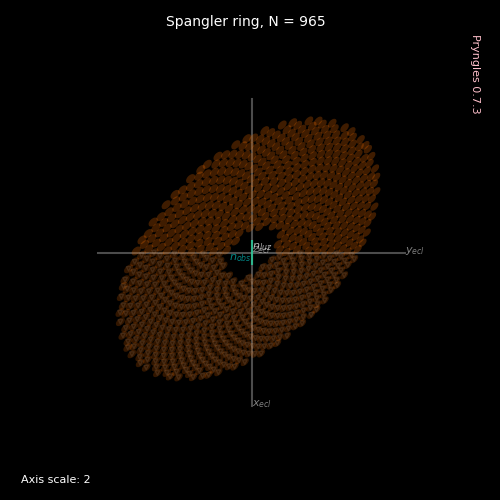

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.


<IPython.core.display.Javascript object>


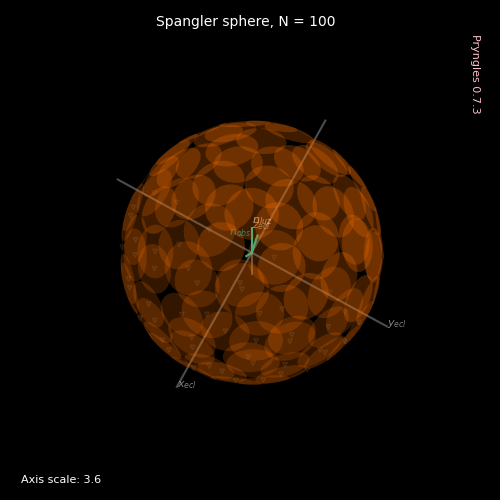

.
----------------------------------------------------------------------
Ran 1 test in 0.975s

OK


In [32]:
if IN_JUPYTER:
    def test_plot3d(self):
        Verbose.VERBOSITY=VERB_SIMPLE

        #No preset
        sg=Spangler(nspangles=850,n_equ=[1,1,1])
        sg.populate_spangler(geometry="ring",preset=True,
                             spangle_type=GASEOUS_SPANGLE,
                             scale=2,ri=0.2)
        sg.data.illuminated=True
        cond=sg.data.x_ecl>0
        sg.data.loc[cond,"visible"]=True
        sg.data.loc[cond,"transmit"]=True
        sg.plot3d()
    
        #Sphere
        sg=Spangler(nspangles=100)
        sg.populate_spangler(geometry="sphere",preset=True,scale=3)
        sg.data.illuminated=True
        cond=sg.data.x_ecl>0
        sg.data.loc[cond,"visible"]=True
        sg.data.loc[cond,"transmit"]=True
        sg.plot3d()
        
        Verbose.VERBOSITY=VERB_NONE
        
    class Test(unittest.TestCase):pass
    Test.test_plot3d=test_plot3d
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

### Set intersection, observer, light-source

In [33]:
def set_intersect(self,nvec,
                  alpha=0,
                  sphash=None
                 ):
    """Set the positions and orientation of spanglers in an intersection direction

    Parametersa:

        nvec: list/array (3), default = []:
            Normal vector towards the observer.

        alpha: float, default = 0:
            Roll angle of x-axis.
            
        sphash: string, default = None:
            Spangler hash to which the transformation will be applied.

    Return:
        None

    Update:

        Coordinates of the spangles, (x_int,y_int,z_int).

        Normal to spangles, ns_int.

        Rotation matrices M_ecl2obs, M_int2ecl, 
    """
    verbose(VERB_SIMPLE,f"Setting intersect")

    verbose(VERB_VERIFY,f"Generating intersect matrices from nvec = {nvec}")
    #Unitary observer vector
    n_int,d_int=spy.unorm(nvec)
    alpha_int=alpha
    rqf_int=sci.spherical(n_int)

    #Transformation matrices
    M_int2ecl,M_ecl2int=Science.rotation_matrix(n_int,alpha_int)
    
    #Depending on body
    cond=[True]*self.nspangles
    if sphash:
        cond=self.data.sphash==sphash
        
    #Update positions
    self.data.loc[cond,["x_int","y_int","z_int"]]=\
        [np.matmul(M_ecl2int,r) for r in np.array(self.data[cond][["x_ecl","y_ecl","z_ecl"]])]
    
    #Center of the object in the observer reference system
    self.data.loc[cond,"center_int"]=\
        pd.Series([np.matmul(M_ecl2int,r) for r in np.array(self.data.center_ecl)])
    
    #Pseudo-cylindrical coordinates in the observer system
    self.data.loc[cond,["rho_int","az_int","cost_int"]]=\
        [sci.pcylindrical(r) for r in np.array(self.data[cond][["x_int","y_int","z_int"]])-np.vstack(self.data[cond].center_int)]

    #Compute distance to light-source of each spangle
    self.data.loc[cond,"d_int"]=d_int-self.data[cond].z_int #Asuming d_int > radius of the object

    #Direction of spangle with respect to direction
    self.data.loc[cond,"cos_int"]=[np.dot(n_ecl,n_int) for n_ecl in self.data.ns_ecl[cond]]
    
    #Spherical
    self.rqf_obs=sci.spherical(nvec)
    
    #Convex hulls
    for sphash in Misc.flatten([self.sphash]):
        
        #Convex hull of not hidden points
        cond_hull=(self.data.sphash==sphash)&(~self.data.hidden)
        self.qhulls[sphash]=[ConvexHull(self.data[cond_hull][["x_int","y_int"]])]

        #Convex hull of hidden points (for geometries with a hole)
        cond_hull=(self.data.sphash==sphash)&(self.data.hidden)
        if sum(cond_hull)>0:
            self.qhulls[sphash]+=[ConvexHull(self.data[cond_hull][["x_int","y_int"]])]
        
    return cond,n_int,d_int

Spangler.set_intersect=set_intersect

  VERB1::__init__:: Loading sampler from preset: ('ring', {'ri': 0.2})
  VERB1::set_intersect:: Setting intersect


,sphash,spangle_type,dim,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_obs,x_obs,y_obs,z_obs,rho_obs,az_obs,cost_obs,cos_obs,d_obs,center_luz,x_luz,y_luz,z_luz,rho_luz,az_luz,cost_luz,cos_luz,d_luz,center_int,x_int,y_int,z_int,rho_int,az_int,cost_int,cos_int,d_int,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,shadow,indirect,emit,intersect,illuminated,transmit,transit,occult
0,Planet,4,2,2,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",-0.032121,-0.40284,0.0,0.404119,4.63282,0.0,"[0, 0, 1]","[0, 0, 0]",-0.032121,-0.40284,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1.0,0.0,0.0,1.0,0.0,0.0,1.0,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,"[0, 0, 0]",1.0,0.0,0.0,1.0,0.0,0.0,1.0,1,0.013946,0.133256,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False


,sphash,spangle_type,dim,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_obs,x_obs,y_obs,z_obs,rho_obs,az_obs,cost_obs,cos_obs,d_obs,center_luz,x_luz,y_luz,z_luz,rho_luz,az_luz,cost_luz,cos_luz,d_luz,center_int,x_int,y_int,z_int,rho_int,az_int,cost_int,cos_int,d_int,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,shadow,indirect,emit,intersect,illuminated,transmit,transit,occult
964,Ring,4,2,2,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",0.4,-9.797174e-17,0.0,0.4,6.283185,0.0,"[0, 0, 1]","[0, 0, 0]",0.4,-9.797174e-17,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 0.0]",0.4,-9.797174e-17,0.0,0.4,6.283185,0.0,1.0,1,"[0, 0, 0]",1,0,0,1,0,0,1,1,"[0.0, 0.0, 0.0]",0.4,-9.797174e-17,0.0,0.4,6.283185,0.0,1.0,1,0.013946,0.133256,1.0,0.0,True,True,False,False,False,False,False,False,False,False,False,False


<IPython.core.display.Javascript object>


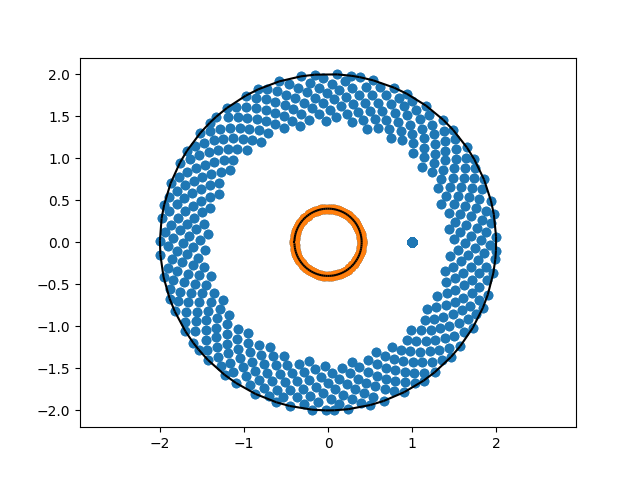

.
----------------------------------------------------------------------
Ran 1 test in 0.359s

OK


In [34]:
if IN_JUPYTER:
    
    def test_setint(self):
        Verbose.VERBOSITY=VERB_SIMPLE

        #No preset
        sg=Spangler(nspangles=850,sphash="Ring")
        sg.populate_spangler(geometry="ring",preset=True,
                             spangle_type=GASEOUS_SPANGLE,
                             scale=2,ri=0.2)
        #sg.set_observer([1,1,1])
        sg.data.loc[:400,"sphash"]="Planet"
        
        cond,n_int,d_int=sg.set_intersect([0,0,1],sphash="Ring")
        sg.data.loc[cond,SPANGLER_COL_OBS]=sg.data.loc[cond,SPANGLER_COL_INT].values
        
        print_df(sg.data.head(1))
        print_df(sg.data.tail(1))

        from scipy.spatial import convex_hull_plot_2d
        fig,ax=plt.subplots()
        ax.scatter(sg.data.x_int,sg.data.y_int)

        convex_hull_plot_2d(sg.qhulls["Ring"][0],ax)
        convex_hull_plot_2d(sg.qhulls["Ring"][1],ax)
        
        ax.axis("equal")
    
        Verbose.VERBOSITY=VERB_NONE
        
    class Test(unittest.TestCase):pass
    Test.test_setint=test_setint
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [35]:
def set_observer(self,nvec=[0,0,1],alpha=0):
    """Set the positions and orientation of spanglers in the observer system.

    Parameters:

        nvec: list/array (3), default = []:
            Normal vector towards the observer.

        alpha: float, default = 0:
            Roll angle of x-axis of observer system (not implemented yet)
    """
    verbose(VERB_SIMPLE,f"Setting observer")
    cond,self.n_obs,self.d_obs=self.set_intersect(nvec,alpha)
    self.data.loc[cond,SPANGLER_COL_OBS]=self.data.loc[cond,SPANGLER_COL_INT].values

Spangler.set_observer=set_observer

  VERB1::__init__:: Loading sampler from preset: ('ring', {'ri': 0.2})
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect


<IPython.core.display.Javascript object>


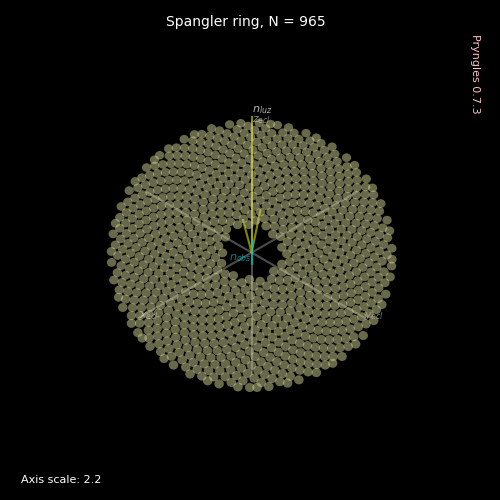

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect


<IPython.core.display.Javascript object>


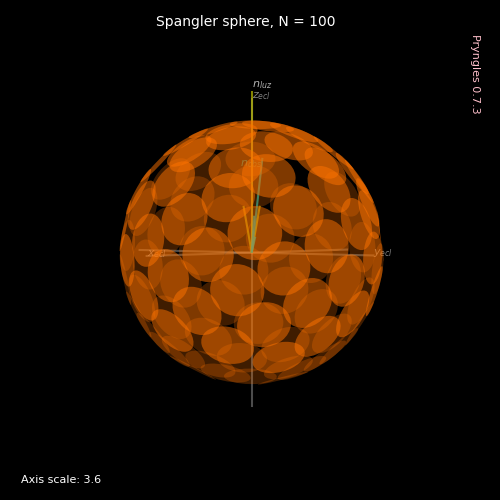

.
----------------------------------------------------------------------
Ran 1 test in 0.846s

OK


In [36]:
if IN_JUPYTER:
    def test_setobs(self):
        Verbose.VERBOSITY=VERB_SIMPLE

        #No preset
        sg=Spangler(nspangles=850,n_equ=[1,1,2])
        sg.populate_spangler(geometry="ring",preset=True,
                             spangle_type=GRANULAR_SPANGLE,
                             scale=2,ri=0.2)
        sg.set_observer([1,1,1])
        sg.data.illuminated=True
        sg.data.loc[sg.data.cos_obs>0,"visible"]=True
        sg.plot3d()
    
        #Sphere
        sg=Spangler(nspangles=100)
        sg.populate_spangler(geometry="sphere",spangle_type=GASEOUS_SPANGLE,preset=True,scale=3)
        sg.set_observer([1,1,1])
        sg.data.illuminated=True
        sg.data.loc[sg.data.cos_obs>0,"visible"]=True
        sg.plot3d()
        
        Verbose.VERBOSITY=VERB_NONE
        
    class Test(unittest.TestCase):pass
    Test.test_setobs=test_setobs
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [37]:
def set_luz(self,nvec=[0,0,1],sphash=None):
    """Set the positions and orientation of spanglers in the light-source system.

    Parameters:

        nvec: list/array (3), default = []:
            Normal vector towards the observer.

        sphash: string, default = None:
            Body to apply this light direction

    """
    verbose(VERB_SIMPLE,f"Setting light-source")
    cond,self.n_luz,self.d_luz=self.set_intersect(nvec=nvec,sphash=sphash)
    self.data.loc[cond,SPANGLER_COL_LUZ]=self.data.loc[cond,SPANGLER_COL_INT].values

Spangler.set_luz=set_luz

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect


<IPython.core.display.Javascript object>


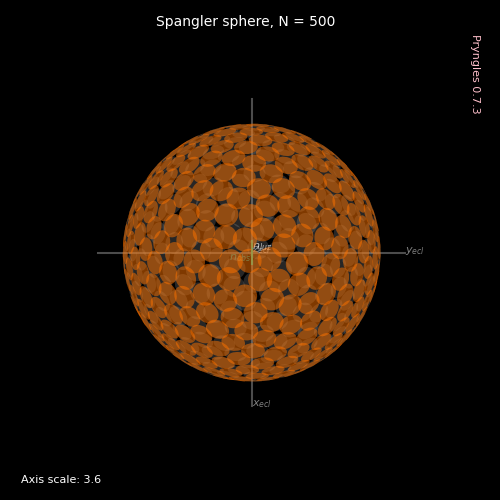

  VERB1::__init__:: Loading sampler from preset: ('ring', {'ri': 0.2})
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect


<IPython.core.display.Javascript object>


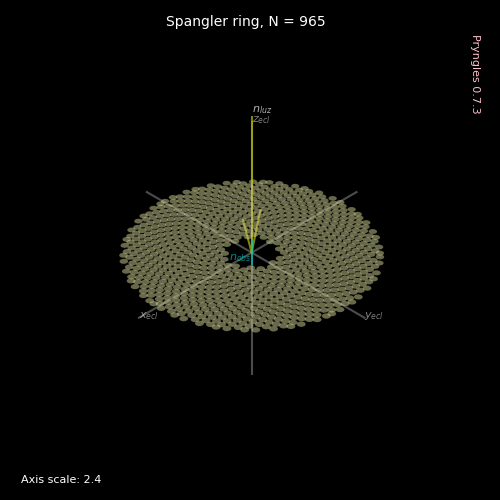

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::__init__:: Joining 2 spanglers
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect


<IPython.core.display.Javascript object>


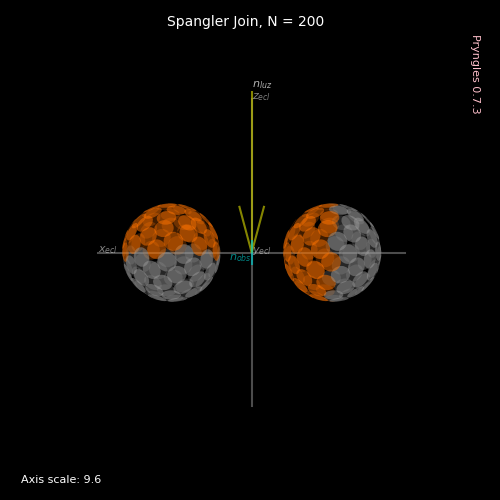

.
----------------------------------------------------------------------
Ran 1 test in 1.627s

OK


In [38]:
if IN_JUPYTER:
    def test_setluz(self):
        
        Verbose.VERBOSITY=VERB_SIMPLE

        #Sphere
        sg=Spangler(nspangles=500)
        sg.populate_spangler(geometry="sphere",spangle_type=GASEOUS_SPANGLE,preset=True,scale=3)
 
        sg.set_observer([0,0,1])
        sg.data.loc[sg.data.cos_obs>0,"visible"]=True

        sg.set_luz([0,0,1])
        sg.data.loc[sg.data.cos_luz>0,"illuminated"]=True

        sg.plot3d()
        
        #Ring
        sg=Spangler(nspangles=850)
        sg.populate_spangler(geometry="ring",preset=True,
                             spangle_type=GRANULAR_SPANGLE,
                             scale=2,ri=0.2)

        sg.set_observer([1,1,+1])
        sg.data.visible=True

        sg.set_luz([0,0,+1])
        sg.data.illuminated=True
        sg.data.loc[(sg.data.cos_luz*sg.data.cos_obs)<0,"transmit"]=True
        
        sg.plot3d()
        
        #Two spheres
        sg1=Spangler(sphash="Star 1",nspangles=100,center_equ=[-5,0,0])
        sg1.populate_spangler(geometry="sphere",spangle_type=GASEOUS_SPANGLE,preset=True,scale=3)
        
        sg2=Spangler(sphash="Star 2",nspangles=100,center_equ=[+5,0,0])
        sg2.populate_spangler(geometry="sphere",spangle_type=GASEOUS_SPANGLE,preset=True,scale=3)
        
        sg=Spangler(spanglers=[sg1,sg2])

        sg.set_observer([0,1,0])
        sg.data.loc[sg.data.cos_obs>0,"visible"]=True

        sg.set_luz(nvec=[1,0,0],sphash="Star 1")
        sg.set_luz(nvec=[0,0,1],sphash="Star 2")
        sg.data.loc[sg.data.cos_luz>0,"illuminated"]=True

        sg.plot3d()
        
        Verbose.VERBOSITY=VERB_NONE
        
    class Test(unittest.TestCase):pass
    Test.test_setluz=test_setluz
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

### Simple state updater

In [39]:
def update_simple_state(self):
    """Update spangle states with the simplest algorithm
    """
    self.data.unset=False
    
    #Condition for visibility
    """
    & ! Hidden
        (
            | cos_obs > 0: spangler it is towards the observer
            | Spangle type is semitransparent
        )
    """
    cond=\
    (~self.data.hidden)&\
    (\
        (self.data.cos_obs>0)|\
        (self.data.spangle_type.isin(SEMITRANSPARENT_SPANGLES))
    )
    self.data.loc[cond,"visible"]=True
    
    #Condition for illumination
    """
    & ! Hidden
        (
            | dim = 2: 2d spangles are always illuminated
            | cos_luz > 0: spangler it is towards the light source
            | Spangle type is stellar
        )
    """
    cond=\
    (~self.data.hidden)&\
    (\
        (self.data.dim==2)|\
        (self.data.cos_luz>0)|\
        (self.data.spangle_type==STELLAR_SPANGLE)
    )
    self.data.loc[cond,"illuminated"]=True

    #Conditions for transmission:
    """
    & No hidden
    (
        & Spangle type is semitransparent
        & cos_obs . cos_luz < 0: observer and light source are in opposite sides
    )
    """
    #"""
    cond=\
    (~self.data.hidden)&\
    (\
     (self.data.spangle_type.isin(SEMITRANSPARENT_SPANGLES))&\
     ((self.data.cos_luz*self.data.cos_obs)<=0)
    )
    self.data.loc[cond,"transmit"]=True
    #"""
    
Spangler.update_simple_state=update_simple_state

  VERB1::__init__:: Loading sampler from preset: ('ring', {'ri': 0.3})
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect


<IPython.core.display.Javascript object>


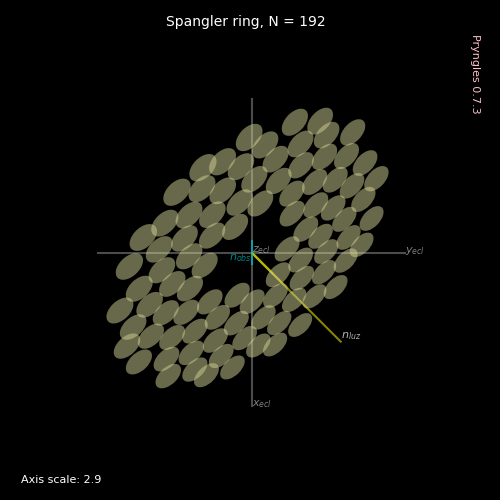

  VERB1::__init__:: Loading sampler from preset: ('ring', {'ri': 0.3})
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect


<IPython.core.display.Javascript object>


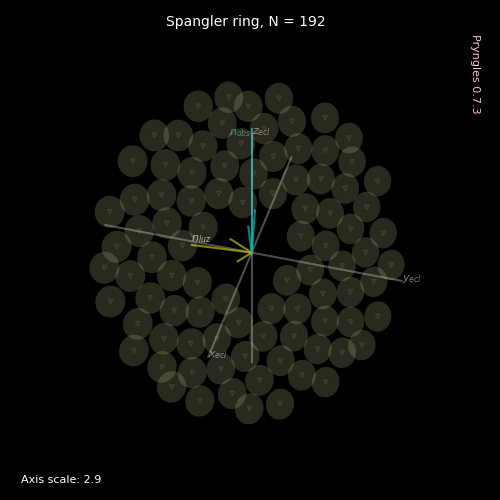

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect


<IPython.core.display.Javascript object>


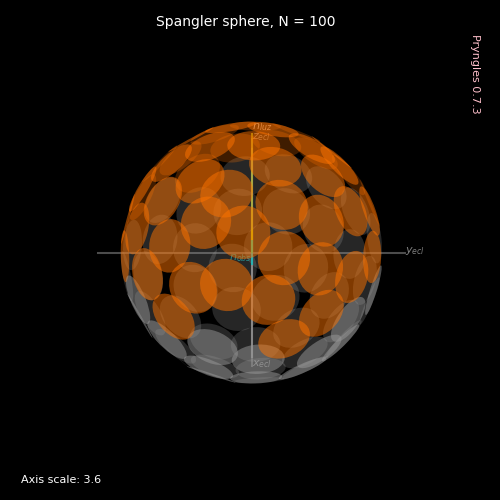

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect


<IPython.core.display.Javascript object>


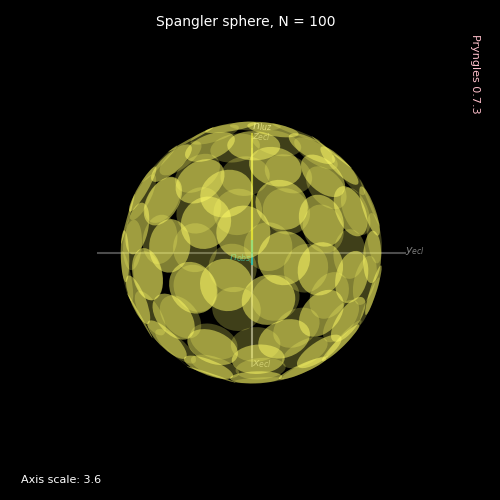

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect


<IPython.core.display.Javascript object>


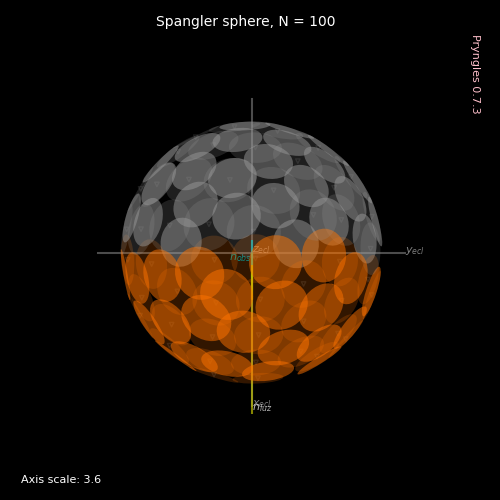

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::__init__:: Joining 2 spanglers
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect


<IPython.core.display.Javascript object>


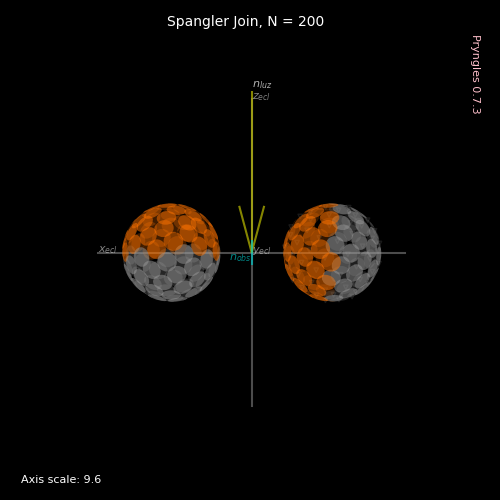

.
----------------------------------------------------------------------
Ran 1 test in 1.337s

OK


In [40]:
if IN_JUPYTER:
    def test_simplevis(self):
        
        Verbose.VERBOSITY=VERB_SIMPLE

        #Ring with semitransparent spangle: all illuminated, all visible, no transmission
        sg=Spangler(nspangles=100,n_equ=[1,1,1])
        sg.populate_spangler(geometry="ring",ri=0.3,spangle_type=GRANULAR_SPANGLE,preset=True,scale=3)
        sg.set_observer([0,0,1])
        sg.set_luz([1,1,-1])
        sg.update_simple_state()
        sg.plot3d()

        #Ring with semitransparent spangle: all illuminated, all visible, no transmission
        sg=Spangler(nspangles=100,n_equ=[1,1,1])
        sg.populate_spangler(geometry="ring",ri=0.3,spangle_type=GRANULAR_SPANGLE,preset=True,scale=3)
        sg.set_observer([0,0,1])
        sg.set_luz([-1,-1,-1])
        sg.update_simple_state()
        sg.plot3d()
        
        #Sphere with solid spangle: only illuminated 
        sg=Spangler(nspangles=100,n_equ=[1,1,1])
        sg.populate_spangler(geometry="sphere",spangle_type=SOLID_SPANGLE,preset=True,scale=3)
        sg.set_observer([1,0,1])
        sg.set_luz([0,0,1])
        sg.update_simple_state()
        sg.plot3d()
        
        #Sphere with stellar spangle: all illuminated, not all visible
        sg=Spangler(nspangles=100,n_equ=[1,1,1])
        sg.populate_spangler(geometry="sphere",spangle_type=STELLAR_SPANGLE,preset=True,scale=3)
        sg.set_observer([1,0,1])
        sg.set_luz([0,0,1])
        sg.update_simple_state()
        sg.plot3d()

        #Sphere with semitransparent spangle: all illuminated, all visible
        sg=Spangler(nspangles=100,n_equ=[1,1,1])
        sg.populate_spangler(geometry="sphere",spangle_type=GASEOUS_SPANGLE,preset=True,scale=3)
        sg.set_observer([0,0,1])
        sg.set_luz([1,0,0])
        sg.update_simple_state()
        sg.plot3d()

        #Two spheres
        sg1=Spangler(sphash="Star 1",nspangles=100,center_equ=[-5,0,0])
        sg1.populate_spangler(geometry="sphere",spangle_type=GASEOUS_SPANGLE,preset=True,scale=3)
        
        sg2=Spangler(sphash="Star 2",nspangles=100,center_equ=[+5,0,0])
        sg2.populate_spangler(geometry="sphere",spangle_type=SOLID_SPANGLE,preset=True,scale=3)
        
        sg=Spangler(spanglers=[sg1,sg2])

        sg.set_observer([0,1,0])
        sg.set_luz(nvec=[1,0,0],sphash="Star 1")
        sg.set_luz(nvec=[0,0,1],sphash="Star 2")
        sg.update_simple_state()
        
        sg.plot3d()
        
        Verbose.VERBOSITY=VERB_NONE
        
    class Test(unittest.TestCase):pass
    Test.test_simplevis=test_simplevis
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

### Plot observer

In [41]:
def plot_obs(self,show_hidden=True,center_at=None,not_plot=[],**args):
    """
    Plot spangle.

    Optional parameters:
    
        show_hidden: boolean, default = True:
            If True show hidden spangles (used to create convex hull of objects).
            
        center_at: string, default = None:
            Hash of the object around which the plotting will be centered at (see sphash column
            of the Spangler DataFrame).
            
        args: dictionary, default = dict(c='c',s=0.1):
            Scatter plotting options, dictionary.
    """
    sargs=dict(c='c',sizes=3.5)
    sargs.update(args)
    bgcolor='k'

    #Center of plot
    cond=(self.data.sphash==center_at)
    x_cen,y_cen,z_cen=self.data[cond][["x_obs","y_obs","z_obs"]].mean() if sum(cond)>0 else np.array([0,0,0])

    #Maxval original
    maxval_full=1.2*np.abs(self.data[["x_obs","y_obs","z_obs"]].to_numpy()-[x_cen,y_cen,z_cen]).max()

    #Select plotting bodies
    yes_plot=(~self.data.sphash.isin(not_plot))
    nyes_plot=sum(yes_plot)
    if nyes_plot==0:
        raise AssertionError(f"No body remain after removing {not_plot}")
    data=self.data[yes_plot]
    
    #Select scale for plot
    cond=cond if sum(cond)>0 else [True]*nyes_plot        
    maxval=1.2*np.abs(data[cond][["x_obs","y_obs","z_obs"]].to_numpy()-[x_cen,y_cen,z_cen]).max()
    size_factor=maxval_full/maxval
        
    #Figure
    fig=plt.figure(figsize=(5,5))
    fig.patch.set_facecolor(bgcolor)
    ax=fig.add_subplot(111,facecolor=bgcolor)
    ax.axis("off")

    #Plot according to state
    colors=np.array(['#000000']*nyes_plot) #Black
    sizes=np.array([0.0]*nyes_plot)

    #No illuminated
    cond=(data.visible)&(~data.illuminated)
    colors[cond]=Misc.rgb(SHADOW_COLOR_OBS,to_hex=True) #Gray
    sizes[cond]=3.5*size_factor*data.scale[cond]

    #Illuminated
    cond=(data.visible)&(data.illuminated)
    colors[cond]=[Misc.rgb([SPANGLE_COLORS[stype][0],
                            SPANGLE_COLORS[stype][1]*min((cos_luz*cos_obs+0.3),1),
                            SPANGLE_COLORS[stype][2]],
                           to_hex=True) for stype,cos_luz,cos_obs in zip(data[cond].spangle_type,
                                                                       abs(data[cond].cos_luz),
                                                                       abs(data[cond].cos_obs))
                 ] #Object color
    sizes[cond]=3.5*size_factor*data.scale[cond]

    #Transmit
    cond=(data.visible)&(data.transmit)
    colors[cond]=[Misc.rgb([SPANGLE_COLORS[stype][0],
                            SPANGLE_COLORS[stype][1]*min((cos_luz*cos_obs+0.3),1),
                            SPANGLE_COLORS[stype][2]],
                            to_hex=True) for stype,cos_luz,cos_obs in zip(data[cond].spangle_type,
                                                                       abs(data[cond].cos_luz),
                                                                       abs(data[cond].cos_obs))
                 ] #Object color
    sizes[cond]=0.5*size_factor*data.scale[cond]

    #No illuminated
    cond=(data.unset)
    colors[cond]=Misc.rgb(SHADOW_COLOR_OBS,to_hex=True) #Gray
    sizes[cond]=3.5*size_factor*data.scale[cond]
    
    #Plots
    sargs.update(dict(c=colors,sizes=sizes))    
    ax.scatter(data.x_obs-x_cen,data.y_obs-y_cen,**sargs)
    
    #Show hidden spangles
    if show_hidden:
        cond=(self.data.hidden)
        sargs.update(dict(c='r',sizes=1.5*data.scale[cond],ec='r',fc='r'))    
        ax.scatter(data.x_obs[cond]-x_cen,data.y_obs[cond]-y_cen,**sargs)

    #Ranges
    ax.set_xlim(-maxval,maxval)
    ax.set_ylim(-maxval,maxval)
    
    factor=1
    xmin,xmax=factor*np.array(list(ax.get_xlim()))
    ymin,ymax=factor*np.array(list(ax.get_ylim()))

    #Axis
    ax.plot([xmin,xmax],[0,0],'w-',alpha=0.3)
    ax.plot([0,0],[ymin,ymax],'w-',alpha=0.3)
    ax.text(xmax,0,r"$x_{obs}$",color='w',alpha=0.5,fontsize=8)
    ax.text(0,ymax,r"$y_{obs}$",color='w',alpha=0.5,fontsize=8)

    #Title
    lamb_obs=self.rqf_obs[1]*Consts.rad
    phi_obs=self.rqf_obs[2]*Consts.rad        
    label_obs=f"Obs ($\lambda$,$\\beta$) : ({lamb_obs:.1f}$^\circ$,{phi_obs:.1f}$^\circ$)"
    ax.set_title(f"Spangler {self.geometry}, N = {self.nspangles}, {label_obs}",
                 color='w',fontsize=10,position=(0.5,+0.5),ha='center')
    Plot.pryngles_mark(ax)

    #Scale
    center_text=""
    if center_at:
        center_text=f", Center at '{center_at}'"
    ax.text(0,0,f"Axis scale: {maxval*factor:.2g}{center_text}",
              fontsize=8,color='w',
              transform=ax.transAxes)

    #Decoration
    fig.tight_layout()
    self.fig2d=fig
    self.ax2d=ax

Spangler.plot_obs=plot_obs

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect


<IPython.core.display.Javascript object>


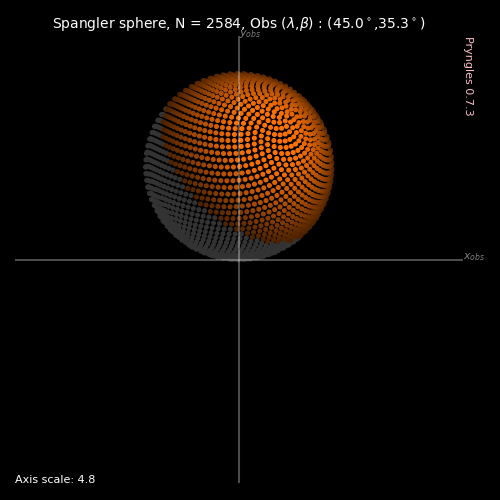

.
----------------------------------------------------------------------
Ran 1 test in 0.492s

OK


In [42]:
if IN_JUPYTER:
    def test_plotobs(self):
        
        Verbose.VERBOSITY=VERB_SIMPLE
        
        plt.close("all")
        sg=Spangler(nspangles=2500,sphash="123",n_equ=[1,1,1],center_ecl=[0,0,2])
        sg.populate_spangler(geometry="sphere",spangle_type=SOLID_SPANGLE,scale=2,seed=1,preset=True)
        sg.set_observer(nvec=[1,0,0])
        sg.set_luz(nvec=[1,1,1])
        sg.update_simple_state()
        sg.plot_obs()
        return
        
        sg=Spangler(nspangles=500,sphash="123",n_equ=[1,1,1],center_ecl=[1,1,1])

        sg.populate_spangler(geometry="sphere",spangle_type=SOLID_SPANGLE,scale=2,seed=1,preset=True)
        sg.set_observer(nvec=[1,0,0])
        sg.plot_obs()

        sg.populate_spangler(geometry="circle",spangle_type=GRANULAR_SPANGLE,scale=2,seed=1,boundary=0)
        sg.plot_obs()

        sg.set_luz(nvec=[0,0,-1])
        sg.populate_spangler(geometry="ring",spangle_type=GRANULAR_SPANGLE,scale=2,seed=1,ri=0.2,boundary=0)
        sg.plot_obs(center_at="123",show_hidden=0)
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_plotobs=test_plotobs
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

### Test join

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::__init__:: Joining 2 spanglers
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect


<IPython.core.display.Javascript object>


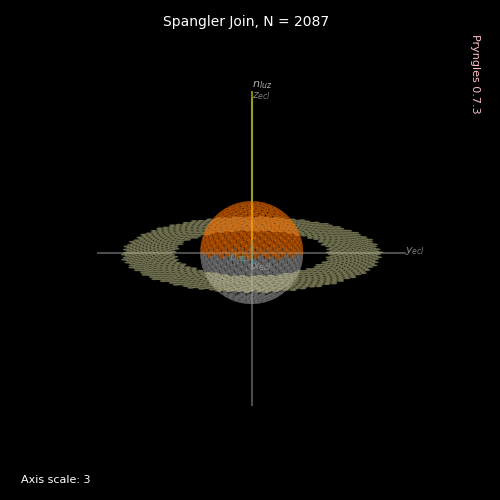

<IPython.core.display.Javascript object>


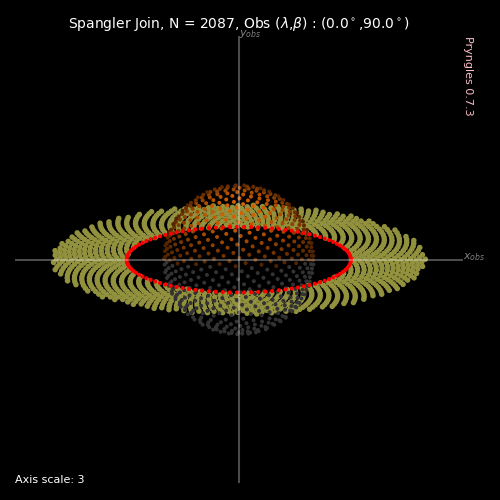

.
----------------------------------------------------------------------
Ran 1 test in 1.530s

OK


In [93]:
if IN_JUPYTER:
    def test_join(self):
        
        Verbose.VERBOSITY=VERB_SIMPLE

        sg1=Spangler(nspangles=1000,sphash="Ring",n_equ=[1,0,5])
        sg1.populate_spangler(geometry="ring",spangle_type=GRANULAR_SPANGLE,scale=2.5,seed=1,ri=1.5/2.5,boundary=0)

        sg2=Spangler(nspangles=1000,sphash="Planet",n_equ=[0,0,1])
        sg2.populate_spangler(geometry="sphere",spangle_type=SOLID_SPANGLE,scale=1,seed=1,preset=True)

        sgj=Spangler(spanglers=[sg1,sg2])
        
        sgj.set_observer([1,0,0.1])
        sgj.set_luz([0,0,1])
        sgj.update_simple_state()
        
        sgj.plot3d()
        sgj.plot_obs()
        
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_join=test_join
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::__init__:: Joining 2 spanglers
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect


<IPython.core.display.Javascript object>


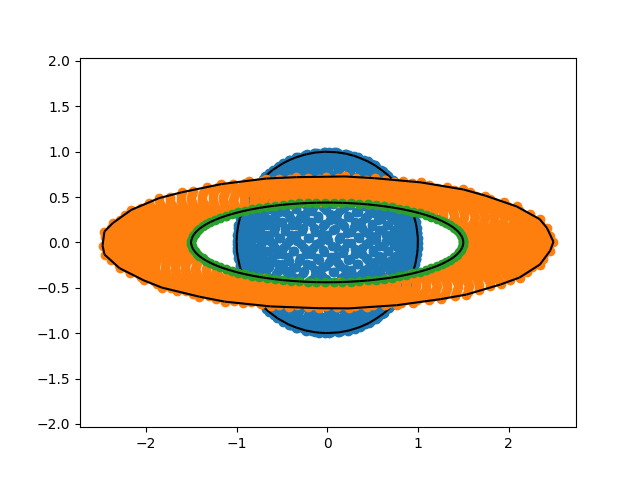

  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect


<IPython.core.display.Javascript object>


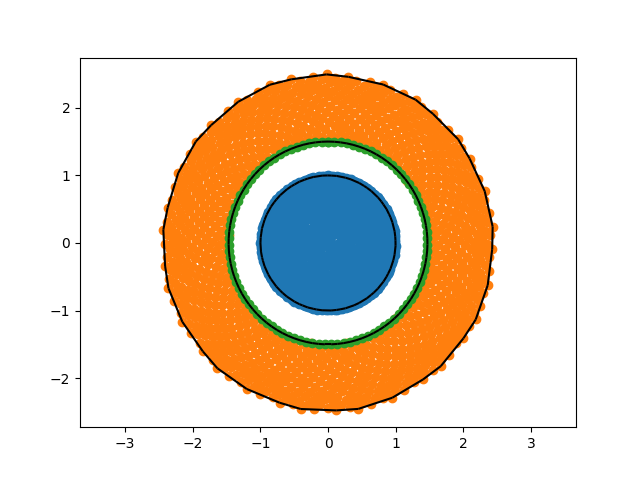

.
----------------------------------------------------------------------
Ran 1 test in 0.665s

OK


In [92]:
if IN_JUPYTER:
    def test_hulls(self):
        
        Verbose.VERBOSITY=VERB_SIMPLE

        sg1=Spangler(nspangles=1000,sphash="Ring",n_equ=[1,0,5])
        sg1.populate_spangler(geometry="ring",spangle_type=GRANULAR_SPANGLE,scale=2.5,seed=1,ri=1.5/2.5,boundary=0)
        sg2=Spangler(nspangles=1000,sphash="Planet",n_equ=[0,0,1])
        sg2.populate_spangler(geometry="sphere",spangle_type=SOLID_SPANGLE,scale=1,seed=1,preset=True)
        sgj=Spangler(spanglers=[sg1,sg2])
        sgj.set_observer([1,0,0.1])
        
        #Hulls of obsever
        fig,ax=plt.subplots()
        cond=sgj.data.visible
        ax.scatter(sgj.data[cond].x_int,sgj.data[cond].y_int)
        f=convex_hull_plot_2d(sgj.qhulls["Planet"][0],ax)
        f=convex_hull_plot_2d(sgj.qhulls["Ring"][0],ax)
        f=convex_hull_plot_2d(sgj.qhulls["Ring"][1],ax)
        ax.axis("equal")

        sgj.set_luz([0,0,1])
        #Hulls of light
        fig,ax=plt.subplots()
        cond=sgj.data.visible
        ax.scatter(sgj.data[cond].x_int,sgj.data[cond].y_int)
        f=convex_hull_plot_2d(sgj.qhulls["Planet"][0],ax)
        f=convex_hull_plot_2d(sgj.qhulls["Ring"][0],ax)
        f=convex_hull_plot_2d(sgj.qhulls["Ring"][1],ax)
        ax.axis("equal")
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_hulls=test_hulls
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

### Update intersection state

In [28]:
def update_intersection_state(self):
    """Update state of intersections
    """
    
    
Spangler.update_intersection_state=update_intersection_state

--End--

<IPython.core.display.Javascript object>


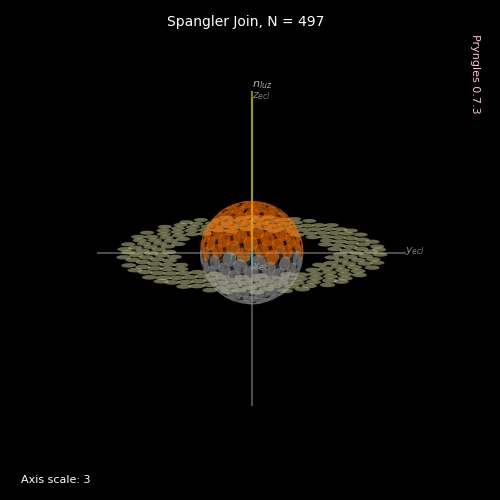

<IPython.core.display.Javascript object>


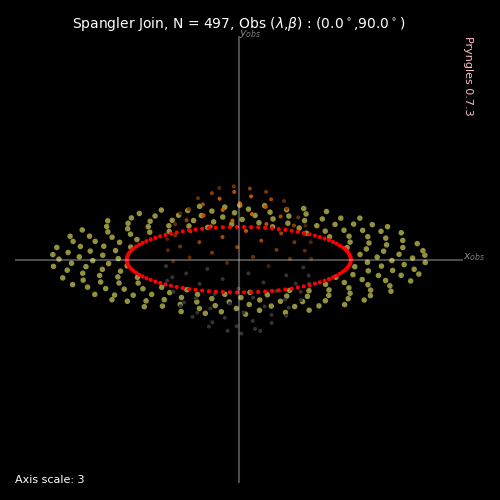

In [61]:
Verbose.VERBOSITY=VERB_NONE
nspangles=200
sg1=Spangler(nspangles=nspangles,sphash="Ring",n_equ=[1,0,5])
sg1.populate_spangler(geometry="ring",spangle_type=GRANULAR_SPANGLE,scale=2.5,seed=1,ri=1.5/2.5,boundary=0,preset=True)

sg2=Spangler(nspangles=nspangles,sphash="Planet",n_equ=[0,0,1])
sg2.populate_spangler(geometry="sphere",spangle_type=SOLID_SPANGLE,scale=1,seed=1,preset=True)

sgj=Spangler(spanglers=[sg1,sg2])

sgj.set_observer([1,0,0.1])
sgj.set_luz([0,0,1])

sgj.update_simple_state()
        
sgj.plot3d()
sgj.plot_obs()
self=sgj

<IPython.core.display.Javascript object>


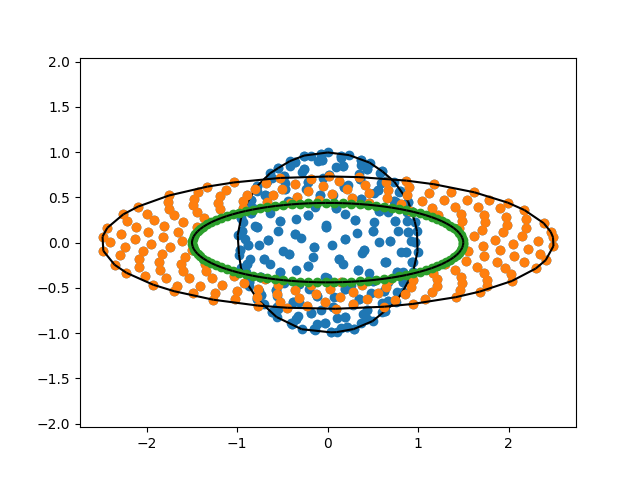

(-2.738590559709909,
 2.7460157794370437,
 -1.0914467873402498,
 1.0967430316614897)

In [85]:
self.set_intersect([1,0,0.1])
fig,ax=plt.subplots()
cond=self.data.visible
ax.scatter(self.data[cond].x_int,self.data[cond].y_int)
f=convex_hull_plot_2d(self.qhulls["Planet"][0],ax)
f=convex_hull_plot_2d(self.qhulls["Ring"][0],ax)
f=convex_hull_plot_2d(self.qhulls["Ring"][1],ax)
ax.axis("equal")

In [94]:
print_df(sgj.data.head())

,sphash,spangle_type,dim,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_obs,x_obs,y_obs,z_obs,rho_obs,az_obs,cost_obs,cos_obs,d_obs,center_luz,x_luz,y_luz,z_luz,rho_luz,az_luz,cost_luz,cos_luz,d_luz,center_int,x_int,y_int,z_int,rho_int,az_int,cost_int,cos_int,d_int,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,shadow,indirect,emit,intersect,illuminated,transmit,transit,occult
0,Ring,3,2,2.5,"[0.19611613513818402, 0.0, 0.98058067569092]",0,0,0,"[0, 0, 0]",0.149598,-1.499780,0.0,1.507223,4.811807,0.0,"[0, 0, 1]","[0, 0, 0]",1.470655,0.149598,-0.294131,"[0.19611613513818404, 0.0, 0.9805806756909201]","[0.0, 0.0, 0.0]",0.149598,-0.439007,1.434090,0.463796,5.040812,0.951478,0.292714,-0.429102,"[0.0, 0.0, 0.0]",1.470655,0.149598,-0.294131,1.478244,0.101373,-0.195148,0.980581,1.294131,"[0.0, 0.0, 0.0]",0.149598,-0.439007,1.434090,0.463796,5.040812,0.951478,0.292714,-0.429102,0.063467,0.284268,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False
1,Ring,3,2,2.5,"[0.19611613513818402, 0.0, 0.98058067569092]",0,0,0,"[0, 0, 0]",0.907171,1.212816,0.0,1.514557,0.928585,0.0,"[0, 0, 1]","[0, 0, 0]",-1.189264,0.907171,0.237853,"[0.19611613513818404, 0.0, 0.9805806756909201]","[0.0, 0.0, 0.0]",0.907171,0.355009,-1.159695,0.974162,0.373015,-0.765699,0.292714,2.164682,"[0.0, 0.0, 0.0]",-1.189264,0.907171,0.237853,1.495764,2.489950,0.157044,0.980581,0.762147,"[0.0, 0.0, 0.0]",0.907171,0.355009,-1.159695,0.974162,0.373015,-0.765699,0.292714,2.164682,0.063467,0.284268,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False
2,Ring,3,2,2.5,"[0.19611613513818402, 0.0, 0.98058067569092]",0,0,0,"[0, 0, 0]",-1.495337,-0.282864,0.0,1.521856,3.328548,0.0,"[0, 0, 1]","[0, 0, 0]",0.277371,-1.495337,-0.055474,"[0.19611613513818404, 0.0, 0.9805806756909201]","[0.0, 0.0, 0.0]",-1.495337,-0.082798,0.270475,1.497628,3.196907,0.177727,0.292714,0.734513,"[0.0, 0.0, 0.0]",0.277371,-1.495337,-0.055474,1.520845,4.895795,-0.036452,0.980581,1.055474,"[0.0, 0.0, 0.0]",-1.495337,-0.082798,0.270475,1.497628,3.196907,0.177727,0.292714,0.734513,0.063467,0.284268,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False
3,Ring,3,2,2.5,"[0.19611613513818402, 0.0, 0.98058067569092]",0,0,0,"[0, 0, 0]",1.299862,-0.805336,0.0,1.529120,5.728511,0.0,"[0, 0, 1]","[0, 0, 0]",0.789697,1.299862,-0.157939,"[0.19611613513818404, 0.0, 0.9805806756909201]","[0.0, 0.0, 0.0]",1.299862,-0.235733,0.770063,1.321065,6.103783,0.503598,0.292714,0.234925,"[0.0, 0.0, 0.0]",0.789697,1.299862,-0.157939,1.520942,1.024863,-0.103288,0.980581,1.157939,"[0.0, 0.0, 0.0]",1.299862,-0.235733,0.770063,1.321065,6.103783,0.503598,0.292714,0.234925,0.063467,0.284268,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False
4,Ring,3,2,2.5,"[0.19611613513818402, 0.0, 0.98058067569092]",0,0,0,"[0, 0, 0]",-0.416441,1.478834,0.0,1.536350,1.845289,0.0,"[0, 0, 1]","[0, 0, 0]",-1.450116,-0.416441,0.290023,"[0.19611613513818404, 0.0, 0.9805806756909201]","[0.0, 0.0, 0.0]",-0.416441,0.432876,-1.414061,0.600670,2.336846,-0.920403,0.292714,2.419048,"[0.0, 0.0, 0.0]",-1.450116,-0.416441,0.290023,1.508728,3.421245,0.188774,0.980581,0.709977,"[0.0, 0.0, 0.0]",-0.416441,0.432876,-1.414061,0.600670,2.336846,-0.920403,0.292714,2.419048,0.063467,0.284268,1.0,0.0,False,False,False,True,False,False,False,False,True,False,False,False


#### Evaluate superposition

In [ ]:
def update_system_visbility(self):
    """Determine the visibility conditions of the spangles
    """
    #Prepare
    self.sp.data.illuminated=False
    
    #Set invisible the hidden spangles
    cond=(self.sp.data.hidden)
    self.sp.data.loc[cond,"visible"]=False
    
    #Calculate the hull of the bodies in the system
    for body in self.bodies.values():

        #Body information
        bhash=body.hash
        bkind=body.kind
        print(f"Checking body {bhash} ({bkind})")
        
        #All points in body
        cond=(self.sp.data.body_hash==bhash)

        #Range of coordinates
        body.zmin=self.sp.data[cond]["z_obs"].min()
        body.zmed=self.sp.data[cond]["z_obs"].mean()
        body.zmax=self.sp.data[cond]["z_obs"].max()
        print(f"zmin = {body.zmin}, zmed = {body.zmed}, zmax = {body.zmax}")

        if bkind=="Ring":
            #Split ring in two parts
            print("\tSplitting ring in two parts")
            cond_up=(self.sp.data[cond]["z_obs"]>=body.zmed)
            
            data_up=self.sp.data[cond&cond_up][["x_obs","y_obs"]]
            data_down=self.sp.data[cond&(~cond_up)][["x_obs","y_obs"]]
            data_hole=self.sp.data[cond&(self.sp.data[cond].hidden)][["x_obs","y_obs"]]
            
            print("Up:",len(data_up))
            print("Down:",len(data_down))
            
            body.qhull_up=ConvexHull(data_up)
            body.qhull_down=ConvexHull(data_down)
            body.qhull_hole=ConvexHull(data_hole)
            
            #Check position of all points
            inhull_up=sci.points_in_hull(self.sp.data[["x_obs","y_obs"]],body.qhull_up)
            inhull_down=sci.points_in_hull(self.sp.data[["x_obs","y_obs"]],body.qhull_down)
            inhull_hole=sci.points_in_hull(self.sp.data[["x_obs","y_obs"]],body.qhull_hole)
            
            #Points below halfs of the ring
            cond=(~self.sp.data.hidden)&(self.sp.data.body_hash!=bhash)&(self.sp.data.visible)
             
            below=(inhull_up)&(~inhull_hole)&(self.sp.data[cond]["z_obs"]<=body.zmax)
            print(f"Points below middle up of ring: {sum(below)}")
            self.sp.data.loc[below,"visible"]=False

            below=(inhull_down)&(~inhull_hole)&(self.sp.data[cond]["z_obs"]<=body.zmed)
            print(f"Points below middle down of ring: {sum(below)}")
            self.sp.data.loc[below,"visible"]=False
            
        else:
            #Build convex hull
            body.qhull=ConvexHull(self.sp.data[cond][["x_obs","y_obs"]])

            #Check position of all points
            inhull=sci.points_in_hull(self.sp.data[["x_obs","y_obs"]],body.qhull)

            #Points above and below
            cond=(~self.sp.data.hidden)&(self.sp.data.body_hash!=bhash)&(self.sp.data.visible)
            above=(inhull)&(self.sp.data[cond]["z_obs"]>body.zmax)
            print(f"Points above: {sum(above)}")
            below=(inhull)&(self.sp.data[cond]["z_obs"]<body.zmin)
            print(f"Points below: {sum(below)}")
        
            if bkind=="Star":
                #In the case of sources
                self.sp.data.loc[above,"transit"]=True
                self.sp.data.loc[below,"occult"]=True

            #Objects below
            self.sp.data.loc[below,"visible"]=False

System.update_system_visibility=update_system_visbility